# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
  
  # iterate over training data; print label and raw feature
  for i in range(num_examples):
    print(f"Label: {newsgroups_train.target_names[train_labels[i]]} \n{train_data[i]}\n")


Q1(5)

Label: comp.graphics 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: talk.religion.misc 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

Label: sci

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():

    print("WORD UNIGRAM")
    vectorizer = CountVectorizer()
    # fit and transform data into unigram one hot encoding
    X = vectorizer.fit_transform(train_data).toarray()
    # size of vocabulary
    print(f"Size of Vocabulary: {len(vectorizer.get_feature_names_out())}")
    # number of non-zero features divided by number of training examples
    print(f"Avg number of non-zero features per example: {np.count_nonzero(X)/ X.shape[0]}")
    # number of non-zero features divided by number of all features
    print(f"Avg number of non-zero features in matrix: {np.count_nonzero(X)/ (X.shape[0] * X.shape[1])}")
    # get first and last feature string
    print(f"First Feature String: {vectorizer.get_feature_names_out()[0]}")
    print(f"Last Feature String: {vectorizer.get_feature_names_out()[-1]}")

    print("")

    print("WORD UNIGRAM - RESTRICTED VOCABULARY")
    vectorizer = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    # transform data into unigram one hot encoding with restricted vocabulary
    X = vectorizer.transform(train_data).toarray()
    # size of vocabulary
    print(f"Size of Vocabulary: {len(vectorizer.get_feature_names_out())}")
    # number of non-zero features divided by number of training examples
    print(f"Avg number of non-zero features per example: {np.count_nonzero(X)/ X.shape[0]}")

    print("")

    print("CHARACTER BIGRAM AND TRIGRAM")
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,3))
    # fit and transform data into character bigram and trigram one hot encoding
    X = vectorizer.fit_transform(train_data).toarray()
    # size of vocabulary
    print(f"Size of Vocabulary: {len(vectorizer.get_feature_names_out())}")

    print("")

    print("WORD UNIGRAM PRUNED")
    vectorizer = CountVectorizer(min_df=10)
    # fit and transform data into unigram one hot encoding
    X = vectorizer.fit_transform(train_data).toarray()
    # size of vocabulary
    print(f"Size of Vocabulary: {len(vectorizer.get_feature_names_out())}")

    print("")

    print("WORD UNIGRAM")
    vectorizer = CountVectorizer()
    # fit and transform train data into unigram one hot encoding
    X = vectorizer.fit_transform(train_data)
    # vocab for train
    train_vocab = vectorizer.get_feature_names_out()
    # fit and transform dev data into unigram one hot encoding
    X = vectorizer.fit_transform(dev_data)
    # vocab for dev
    dev_vocab = vectorizer.get_feature_names_out()
    # find number of words in dev set that are not in train
    count = 0
    for word in dev_vocab:
      if word not in train_vocab:
        count += 1
    print(f"Fraction of words in dev set that are not in train set: {count / len(train_vocab)}")


Q2()

WORD UNIGRAM
Size of Vocabulary: 26879
Avg number of non-zero features per example: 96.70599803343165
Avg number of non-zero features in matrix: 0.0035978272269590263
First Feature String: 00
Last Feature String: zyxel

WORD UNIGRAM - RESTRICTED VOCABULARY
Size of Vocabulary: 4
Avg number of non-zero features per example: 0.26843657817109146

CHARACTER BIGRAM AND TRIGRAM
Size of Vocabulary: 35478

WORD UNIGRAM PRUNED
Size of Vocabulary: 3064

WORD UNIGRAM
Fraction of words in dev set that are not in train set: 0.14981956173964806


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
  # transform input data into one hot encoded vectors
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(train_data)
  X_dev = vectorizer.transform(dev_data)

  # fit multiple KNN models; evaluate on F1 score
  for k in range(5, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, train_labels)
    print(f"KNN - F1 Score for K={k}: {metrics.f1_score(dev_labels, knn.predict(X_dev), average='weighted')}")

  print("")

  # fit multiple multinomial naive bayes models; evauluate on F1 score
  ALPHAS = [0.001, 0.01, 0.1, 0.5, 1.0]
  for alpha in ALPHAS:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train, train_labels)
    print(f"MNB - F1 Score for alpha={alpha}: {metrics.f1_score(dev_labels, nb.predict(X_dev), average='weighted')}")

  print("")

  # fit mutptiple logistic regression models; evaluate on F1 score
  C = [0.01, 0.1, 0.5, 0.75, 1.0]
  for value in C:
    lr = LogisticRegression(C=value, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)
    print(f"LR - F1 Score for C={value}: {metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')}")
    # calculate sum of squared weights for each topic
    for index, coef in enumerate(lr.coef_):
      print(f"Sum of Squared Weights for Topic {newsgroups_train.target_names[index]}: {np.sum(coef**2)}")


Q3()

KNN - F1 Score for K=5: 0.4287607236218357
KNN - F1 Score for K=6: 0.4466650540867595
KNN - F1 Score for K=7: 0.45047910006117586
KNN - F1 Score for K=8: 0.44698358117081094
KNN - F1 Score for K=9: 0.4365666176198027

MNB - F1 Score for alpha=0.001: 0.7702518836155706
MNB - F1 Score for alpha=0.01: 0.7751663218544357
MNB - F1 Score for alpha=0.1: 0.7903052385098862
MNB - F1 Score for alpha=0.5: 0.7862862961995258
MNB - F1 Score for alpha=1.0: 0.7777320236017224

LR - F1 Score for C=0.01: 0.6646997417582748
Sum of Squared Weights for Topic alt.atheism: 2.541530980704472
Sum of Squared Weights for Topic comp.graphics: 2.9397093683572604
Sum of Squared Weights for Topic sci.space: 2.8624691244205134
Sum of Squared Weights for Topic talk.religion.misc: 2.2500292743089414
LR - F1 Score for C=0.1: 0.6966243542418833
Sum of Squared Weights for Topic alt.atheism: 27.132067887249622
Sum of Squared Weights for Topic comp.graphics: 24.663104303462244
Sum of Squared Weights for Topic sci.space: 27

ANSWER:

- Why doesn't k-Nearest Neighbors work well for this problem?
  - In this case, when we are creating the feature vectors for each training example, they are very sparse. This is because the dimension of our feature vector is equal to the length of our vocabulary. Due to these very sparese vectors, it is hard for KNN to find similar examples when attemping to predict a topic label. 

- Why doesn't Logistic Regression work as well as Naive Bayes does?
  - Logistic regression is attemping to create a regression model for each label. Similar to the reason that KNN does not work very well, it is hard for logistic regression to create a model from this very sparse training data. Thus, is is unable to performn as well compared to somthing like Naive Bayes. 

- What is the relationship between logistic regression's sum of squared weights vs. C value?
 - We can see a very strong relationship between the sum of squared weights and the C value. As increase the C-value, we are lightening the penalty term that is applied when calculating the weights. This means that as we drive down the C-Value, we are also driving the weights down to 0. 


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
  # transform input data into one hot encoded vectors
  vectorizer = CountVectorizer(ngram_range=(2,2))
  X_train = vectorizer.fit_transform(train_data)
  # create and fit logisitic regression model
  lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  lr.fit(X_train, train_labels)

  # find index of 5 largest weights for each class
  largest_weight_idx = []
  for i in range(lr.coef_.shape[0]):
    largest_weight_idx.extend(np.argsort(lr.coef_[i])[-5:])

  
  # iterate over index of largest weights; save weights for all 4 classes
  weights = []
  for index in largest_weight_idx:
    row = [vectorizer.get_feature_names_out()[index]]
    row.extend(lr.coef_[:, index])
    weights.append(row)

  # create dataframe from features; add heatmap 
  return pd.DataFrame(weights, columns=["features"] + (newsgroups_train.target_names)) \
        .style.background_gradient(cmap ='Blues') \
        .set_properties(**{'font-size': '15px'})
Q4()

,features,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,are you,0.446953,-0.248257,-0.097135,-0.305625
1,you are,0.472740,-0.279894,-0.481305,0.028373
2,was just,0.482050,-0.131418,-0.128882,-0.227469
3,cheers kent,0.555720,-0.697918,-0.663766,0.534808
4,claim that,0.605549,-0.199067,-0.274345,-0.140364
5,is there,-0.340882,0.754998,-0.468249,-0.257079
6,out there,-0.274803,0.758658,-0.479057,-0.277089
7,comp graphics,-0.292166,0.801208,-0.370885,-0.285186
8,in advance,-0.459351,0.832567,-0.438501,-0.418453
9,looking for,-0.630341,1.108375,-0.500050,-0.571869


ANSWER: 

I am surprised by many entries in this table. It seems that a lot of them are noise and would not help to better classify a topic. For example, ["are you", "you are", "was just", "claim that", "is there", ...] are all examples of bigrams that do not add any information to the model. I think this may be the reason the logistic regression model is performing very poorly. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def Q5():
  print("NO PREPROCESSING APPLIED")
  # transform input data into one hot encoded vectors
  vectorizer = CountVectorizer(lowercase=False, strip_accents=None) # exclude default preprocessing
  X_train = vectorizer.fit_transform(train_data)
  X_dev = vectorizer.transform(dev_data)
  # create and fit logistic regression model
  lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  lr.fit(X_train, train_labels)
  # size of vocabulary
  no_preprocess_vocab_size = len(vectorizer.get_feature_names_out())
  print(f"Size of Vocabulary: {no_preprocess_vocab_size}")
  # calculate F1 score
  original_f1_score = metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')
  print(f"F1 Score: {original_f1_score}")

  print("")
  
  print("PREPROCESSING APPLIED")
  # transform input data into one hot encoded vectors
  vectorizer = CountVectorizer(stop_words='english', max_df=0.15, strip_accents='unicode')
  X_train = vectorizer.fit_transform(train_data)
  X_dev = vectorizer.transform(dev_data)
  # create and fit logistic regression model
  lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  lr.fit(X_train, train_labels)
  # size of vocabulary
  preprocess_vocab_size = len(vectorizer.get_feature_names_out())
  print(f"Size of Vocabulary: {preprocess_vocab_size}")

  preprocess_f1_score = metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')
  print(f"F1 Score: {preprocess_f1_score}")

  print("")

  # calculate improvement
  print(f"IMPROVEMENT: {preprocess_f1_score - original_f1_score:.2%}")
  print(f"Vocabulary size reduced by {no_preprocess_vocab_size - preprocess_vocab_size} words")

Q5()

NO PREPROCESSING APPLIED
Size of Vocabulary: 33291
F1 Score: 0.7069109185493502

PREPROCESSING APPLIED
Size of Vocabulary: 26568
F1 Score: 0.733921773499919

IMPROVEMENT: 2.70%
Vocabulary size reduced by 6723 words


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 regularization strength=0.001
Vocabulary size: 3
F1 Score: 0.33442786629546206
L1 regularization strength=0.01
Vocabulary size: 17
F1 Score: 0.4625536287338924
L1 regularization strength=0.05
Vocabulary size: 122
F1 Score: 0.6421522899484781
L1 regularization strength=0.1
Vocabulary size: 211
F1 Score: 0.6960795334359047
L1 regularization strength=0.2
Vocabulary size: 364
F1 Score: 0.6829128398673092
L1 regularization strength=0.5
Vocabulary size: 789
F1 Score: 0.6726172433849796
L1 regularization strength=1
Vocabulary size: 1090
F1 Score: 0.678729206808501
L1 regularization strength=2
Vocabulary size: 1746
F1 Score: 0.6963739398998274
L1 regularization strength=5
Vocabulary size: 2690
F1 Score: 0.7007886987352231
L1 regularization strength=10
Vocabulary size: 3401
F1 Score: 0.7031157885775385
L1 regularization strength=20
Vocabulary size: 4112
F1 Score: 0.7022481382022341
L1 regularization strength=50
Vocabulary size: 6072
F1 Score: 0.7091392684903384
L1 regularization strength=100

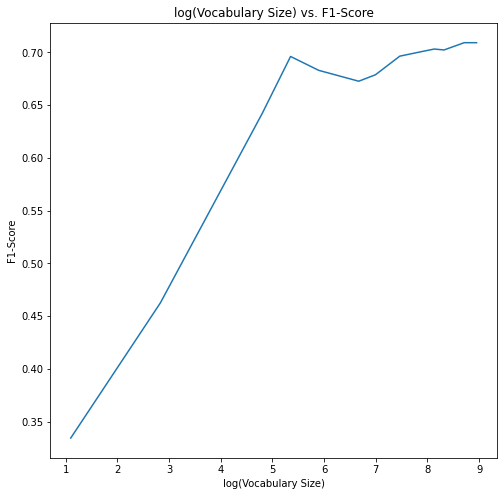

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    C = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    f1_scores = []
    vocabulary_sizes = []
    for value in C:
      print(f"L1 regularization strength={value}")
      # transform input data into one hot encoded vectors
      vectorizer = CountVectorizer()
      X_train = vectorizer.fit_transform(train_data)
      # create and fit logistic regression model with L1 regularization at specific C value
      lr = LogisticRegression(penalty="l1", C=value, solver="liblinear", tol=0.015)
      lr.fit(X_train, train_labels)
      # find features that have non-zero weight associated with them
      vocabulary = vectorizer.get_feature_names_out()[list(set(np.flatnonzero(lr.coef_) % lr.coef_.shape[1]))]
      # vocabulary size
      vocabulary_size = len(vocabulary)
      print(f"Vocabulary size: {vocabulary_size}")
      vocabulary_sizes.append(vocabulary_size)
      # transform input data into one hot encoded vector using the features selected through L1 regularization 
      vectorizer = CountVectorizer(vocabulary=vocabulary)
      X_train = vectorizer.fit_transform(train_data)
      X_dev = vectorizer.transform(dev_data)
      # create and fit a logisitic regression model with L2 regulariztion
      lr = LogisticRegression(penalty="l2", solver="liblinear", C=0.5)
      lr.fit(X_train, train_labels)
      f1_score = metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')
      print(f"F1 Score: {f1_score}")
      f1_scores.append(f1_score)

    print("\n")
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(np.log(vocabulary_sizes), f1_scores)
    ax.set_title("log(Vocabulary Size) vs. F1-Score")
    ax.set_xlabel("log(Vocabulary Size)")
    ax.set_ylabel("F1-Score")
    plt.show()

Q6()

ANSWER: 

From the plot, we can see that as we are increasing the vocabulary size, the F1-Score is also increased. At some point though, we see that as we continue to increase the vocabulary size the F1-Score begins to drop. I would say that this is the point of diminishing returns and we are likely beginning to overfit the model at this point.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
# transform input data into one hot encoded vectors
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data)
vectorizer.get_feature_names_out()
X_train[0]

<1x26879 sparse matrix of type '<class 'numpy.float64'>'
	with 68 stored elements in Compressed Sparse Row format>

In [10]:
def Q7():

    # transform input data into one hot encoded vectors
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    # create logistic regression model and fit on train data
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)
    print(f"F1 Score: {metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')}")

    print("")

    # calculate r ratios for each document 
    predicted_proba = lr.predict_proba(X_dev)
    r_ratios = []
    for y_hats, y in zip(predicted_proba, dev_labels):
      r_ratios.append(max(y_hats) / y_hats[y])

    # print documents with highest r-ratio
    for index in np.argsort(r_ratios)[-3:]:
      print(f"Label: {newsgroups_test.target_names[dev_labels[index]]}")
      print(dev_data[index])
      print("")
    
Q7()

F1 Score: 0.7597662427853104

Label: alt.atheism

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Label: talk.religion.misc
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Label: talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit e

ANSWER: 
- Explain what the R ratio describes.
  - The r-ratio is giving us a score of how correct the model is within each prediction of the test data. If we have achieved an R ratio of one, that means that the classifier has correctly predicted the label. As the R-Ratio increases, this means that the classifier is predicting the incorrect label for a given document to a higher degree.
- What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.
 - I think that in this case, the model is making mistakes because the vocabulary that is being fed contains too many words that provide no information to the model. These very large sparse matrices that the logistic model is being trained on are causing errors within the model. I think that if we pass in some stop words or other other restrictions during the tokenizing of our dataset, the model will improve.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [11]:
def Q8():
   # transform input data into one hot encoded vectors
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.15, strip_accents='unicode')
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    # create logistic regression model and fit on train data
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)
    print(f"F1 Score: {metrics.f1_score(dev_labels, lr.predict(X_dev), average='weighted')}")

Q8()

F1 Score: 0.7848035202593314


By adding stop words, stripping accents, and ignoring words that have a document frequency of less than 15%, we are able to improve the F1-score of the model by 2.5%.